In [15]:
#Math Part
import numpy as np
import pandas as pd
import time

#Graph
import matplotlib.pyplot as plt

import importlib
import circuit
import encoding
import qsvm
import fitness
import gsvm
importlib.reload(circuit)
importlib.reload(encoding)
importlib.reload(qsvm)
importlib.reload(fitness)
importlib.reload(gsvm)

<module 'gsvm' from 'c:\\Users\\londh\\qc\\Automatic_design_of_quantum_feature_maps_Genetic_Auto-Generation-main\\Qkrishi---QSVM\\gsvm.py'>

In [11]:
output="bank_testdata.csv"
df = pd.read_csv('bank_cleaned.csv')
flag = 1

if flag==1:

    bank_data = df.sample(n = 4000)#,random_state=3)

    ones = 0
    for i in bank_data['y']:
        if i > 0:
            ones +=1
    ones_ratio = ones/4000

    if ones_ratio<0.4:
        flag = 1 
        print('hmm')
    else:
        flag = 0


y = bank_data['y'].values
X = bank_data[['age','job','marital','education','default','balance','housing','loan','contact',
                'day','month','duration','campaign','pdays','previous','poutcome']].values
start = time.time()

pop, pareto, logbook = gsvm.gsvm(nqubits=5, depth=3, nparameters=2,
                                    X=X, y=y, weights=[-1.0,1.0],
                                    mu=20,lambda_=10, ngen=7)
print(f'Simulation finished after {time.time()-start} seconds')
print(f'\nGenetic-algorithm output ({output})')

print('---------------------------------------------')
print(logbook,type(logbook))
with open(output, "w") as f:
    for ide, ind in enumerate(pareto):
        genes=''.join(str(i) for i in list(ind))
        gates, acc = ind.fitness.values
        line = f'{ide},"{genes}",{gates},{acc}'
        f.write(line)
        f.write('\n')
        print(line)

multi


d:\Anaconda\envs\qc\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
d:\Anaconda\envs\qc\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


String: 100011000010100000010100111110110100101011110001110110001111110001110001000
 -> accuracy = 0.60125, gates = 10.0,recall = 0.640506329113924
String: 111100011011010001011110111101011100101010101010111011001101101101100111000
 -> accuracy = 0.605, gates = 9.0,recall = 0.6379746835443038
String: 111010000000101101101101011011100110010000110001111011111100100101000111001
 -> accuracy = 0.56875, gates = 14.0,recall = 0.3569620253164557
String: 100011010110110101011101100110010000010100000100010010011001100011000000011
 -> accuracy = 0.55875, gates = 12.0,recall = 0.6075949367088608
String: 110101011011000000010000100011101010101011010110000001001000100010010101110
 -> accuracy = 0.54875, gates = 8.0,recall = 0.529113924050633
String: 011101111000100001000011111100011001101011111000110001010000000011110010000
 -> accuracy = 0.59875, gates = 17.0,recall = 0.6025316455696202
String: 111010100011010001101110110101011011010101110000010011011111100010010011011
 -> accuracy = 0.61125, gate

In [12]:
iot_result = pd.read_csv('bank_testdata.csv',header=None)

def ordenar_salidas_pareto(dataframe):
    dataframe.columns=['ind','circ','gates','accuracy']
    dataframe.sort_values(['gates','accuracy'], ascending=[False,False],inplace=True)
    dataframe.reset_index(inplace=True)
    dataframe.pop('index')
    return dataframe

iot_salidas = ordenar_salidas_pareto(iot_result)
iot_salidas # Queremos ver el primer circuito del dataframe yya ordenado por accuracy (mejor ind)

,ind,circ,gates,accuracy
0,7,1111101011000010111100000011101101001011101111...,2.812813,0.63750
1,5,1101010110110000000100001000111101001011101111...,2.517258,0.63125
2,6,1100110101101111001000100000111010100000101000...,2.517258,0.63125
3,4,0111111000011110111101111110010111001010101010...,2.210090,0.61750
4,2,1010101010111100000111011000101000101010010101...,2.190490,0.60750
5,3,1011011001011110101010000111010111001011010000...,2.190490,0.60750
6,1,1011011001011110101010000010100001001011010000...,1.877070,0.58375
7,0,1111000111000110100100010010010111001010101010...,1.835129,0.55750


['11111', '01011', '00001', '01111', '00000', '01110', '11010', '01011', '10111', '10101', '00011', '11110', '01101', '01111', '01111']
10.0


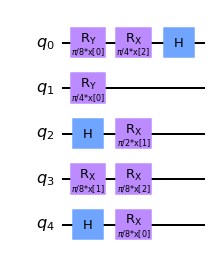

In [13]:
from qiskit.circuit import ParameterVector, QuantumCircuit
from qiskit import QuantumRegister

def coding_bits(b):
    c = [b[n:n+5] for n,i in enumerate(b) if n%5==0]
    c_p=[]
    coding_0=[]
    for i in range(len(c)):
        for j in c[i]:
            c_p.append(str(j))
    np.asarray(c_p)
    c = [c_p[n:n+5] for n,i in enumerate(c_p) if n%5==0]
    for i in c:
        coding_0.append(''.join(i))
    return coding_0

class CircuitConversor:

    def __init__(self, nqubits, nparameters):
        gates = {}
        for n, suffix in enumerate(['00','01','10','11']):
            angle = np.pi / (2**n)
            gates['000'+suffix] = (self.make_H(), 1.0)
            gates['001'+suffix] = (self.make_cx(), 2.0)
            gates['010'+suffix] = (self.make_id(), 0.0)
            gates['011'+suffix] = (self.make_rx(angle), 1.0)
            gates['100'+suffix] = (self.make_rz(angle), 1.0)
            gates['101'+suffix] = (self.make_id(), 0.0)
            gates['110'+suffix] = (self.make_id(), 0.0)
            gates['111'+suffix] = (self.make_ry(angle), 1.0)
        self.gates = gates
        self.nqubits = nqubits
        self.register = QuantumRegister(nqubits, 'q')
        self.nparameters = nparameters
        self.nqubits = nqubits
        self.x = ParameterVector('x', nparameters)

    def __call__(self, coding_0):
        print(coding_0)
        circuit = QuantumCircuit(self.register)
        k = 0
        cost = 0
        for ndx, z in enumerate(coding_0):
            qubit = ndx % self.nqubits
            target = (ndx + 1) % self.nqubits
            fn, weight = self.gates[z]
            k = fn(circuit, k, qubit, target)
            cost += weight
        for i in range(k, self.nparameters):
            circuit.rz(self.x[i]*0, self.register[0])
        return circuit, cost

    def make_id(self):
        def operation(circuit, k, qubit, target):
            return k
        return operation

    def make_H(self):
        def operation(circuit, k, qubit, target):
            circuit.h(self.register[qubit])
            return k
        return operation

    def make_cx(self):
        def operation(circuit, k, qubit, target):
            circuit.cx(self.register[qubit], self.register[target])
            return k
        return operation

    def make_rx(self, angle):
        def operation(circuit, k, qubit, target):
            circuit.rx(self.x[k%self.nparameters] * angle,
                       self.register[qubit])
            return k+1
        return operation

    def make_ry(self, angle):
        def operation(circuit, k, qubit, target):
            circuit.ry(self.x[k%self.nparameters] * angle,
                       self.register[qubit])
            return k+1
        return operation

    def make_rz(self, angle):
        def operation(circuit, k, qubit, target):
            circuit.rz(self.x[k%self.nparameters] * angle,
                       self.register[qubit])
            return k+1
        return operation

cc = CircuitConversor(nqubits=5, nparameters=3)
fm, puertas = cc(coding_bits(iot_salidas.circ[0]))
print(puertas)
fm.draw(output='mpl')

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score, accuracy_score
import matplotlib.pyplot as plt

In [9]:
def featuremap_performance(pop:str,nqubits:int,nparameters:int) -> None:
    '''Returns the performance of a feature map on all of the dataset'''

    df = pd.read_csv('bank_cleaned.csv')
    bank_data = df.sample(n = 20000)

    y = bank_data['y'].values
    X = bank_data[['age','job','marital','education','default','balance',
                'housing','loan','contact','day','month','duration','campaign','pdays','previous','poutcome']].values


    fitness_obj = fitness.Fitness(nqubits,nparameters,X,y,debug=True)

    training_features, training_labels, test_features, test_labels = fitness.Dataset(X,y)

    model = qsvm.QSVM(lambda parameters: fitness_obj.cc(pop, parameters)[0],training_features,training_labels)#fitness_obj(pop)

    y_pred = model.predict(test_features)

    cm = confusion_matrix(test_labels, y_pred)

    #cm_display = ConfusionMatrixDisplay(cm).plot()
    ConfusionMatrixDisplay.from_predictions(test_labels, y_pred)
    plt.show()
    recall = recall_score(test_labels, y_pred)
    acc  = accuracy_score(test_labels, y_pred)

    print(f'String = {pop}, accuracy = {acc}, recall = {recall}')
    
    return None

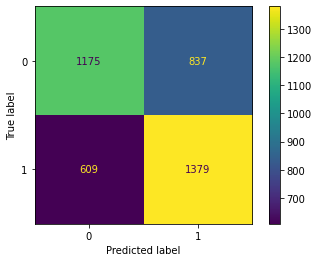

String = 111110101100001011110000001110110100101110111101010001111110011010111101111, accuracy = 0.6385, recall = 0.6936619718309859


In [14]:
featuremap_performance(iot_salidas.circ[0],5,3)